# TinyVLM

## Data Exploration and Initial Preprocessing

### Data Exploration

##### Data

- [Images used for training with descriptions](https://huggingface.co/datasets/BAAI/CapsFusion-120M)
- [Instruction Tuning #1](https://textvqa.org/dataset/)
- [Instruction Tuning #2](https://visualqa.org/download.html)

General Info on our Data:

- Our dataset provides over 13 million image links, but we are scaling down. We downloaded the first 5 million rows of the dataset, and of these we will only use the rows where the image link gives a successful response code.
- All initial images are not uniform in any regard, however during preprocessing, all images will be cropped
- 3 different descriptions for each images as features

### Preprocessing Steps

For preprocessing, we plan on doing the following:

- Downloading only images in which gives a successful response code (rows in the dataset corresponding to images without a successful response code will be disregarded)
- Cropping all the images to a desired 128 x 128 dimension
- Normalization is likely not needed, however will perform when needed
- Classification of the data, classifying each of the features
- Encorporate image descriptions to the desired images for training
- Prepare questions and answers for images to do instruction Tuning to the LLM pre-train model

Our dataset consists of images with a wide variety of aspect ratios. Some images are already square or nearly square, whereas others have extreme aspect ratios (very narrow/wide). To account for this, we will set an aspect ratio threshold of 0.6, where aspect ratio is defined as the minimum of the width and height over the maximum of the width and height. For images with an aspect ratio greater than or equal to 0.6, we will center crop the image, and images with an aspect ratio less than 0.6 will be padded. An example of our preprocessing for a single image is as follows: Say we have a very narrow image with a height of 400px and a width of 100px. The image will be padded to make it square, meaning black bars will be added to the left and right of the image, each one having a height of 400px and a width of 150px. The image will then be downscaled to 128x128.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/image_metadata_0.csv')
print(f'Shape of our Dataframe{df.shape}')
print()
df.head()

Shape of our Dataframe(100000, 5)



,image_url,capsfusion,identifier,original_width,original_height
0,http://ih3.redbubble.net/image.12080909.2547/f...,"The Lego minifigure, known as Minifig [Rainbow...",515623f9-0f34-49b1-be2c-253636badaf6,NaN,NaN
1,https://cdn.shopify.com/s/files/1/2161/7557/pr...,"The Chilly Grip H2O Waterproof Thermal Lined, ...",ccb9ec94-d0d4-4384-b728-a8d9ad150aa6,439.0,480.0
2,http://i0.wp.com/www.ladycarehealth.com/wp-con...,Abdominal cramping is a common sign of pregnan...,642a0186-bbc4-4244-b87b-617d4ea350ed,NaN,NaN
3,https://cdn.shopify.com/s/files/1/2986/1514/pr...,This lovely 1930s Velveteen Burgundy Half Slee...,9be0e45a-bdd0-410d-b825-77b3781eaa84,800.0,1156.0
4,https://cdn.shopify.com/s/files/1/2169/9777/pr...,The Bubblegum Divas Store offers a Little Yell...,b75f96ac-c759-415c-91de-4502da4a3156,100.0,100.0


24178
75822


Text(0.5, 1.0, 'Image download in total')

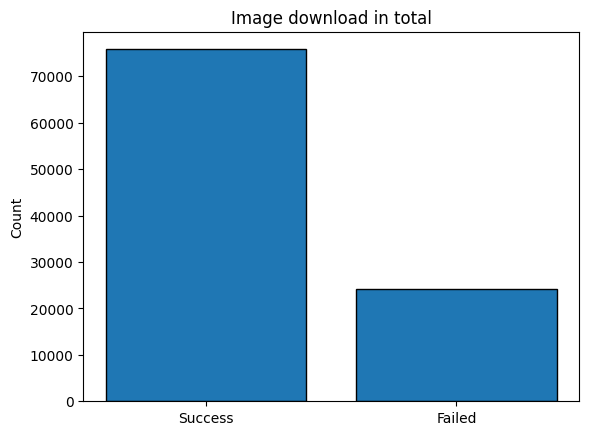

In [ ]:
fail_download = df.isna().any(axis=1).sum()
downloaded = df.shape[0] - fail_download
label = ['Success', 'Failed']
count = [downloaded, fail_download]
plt.bar(label, count,  edgecolor='black')
plt.ylabel('Count')
plt.title('Image download in total')

Drop all the null value and compute the aspect ratio for each picture

In [6]:
df = df.dropna()
df['aspect_ratio'] = np.minimum(df['original_height'], df['original_width']) / np.maximum(df['original_height'], df['original_width'])
df.head()

,image_url,capsfusion,identifier,original_width,original_height,aspect_ratio
1,https://cdn.shopify.com/s/files/1/2161/7557/pr...,"The Chilly Grip H2O Waterproof Thermal Lined, ...",ccb9ec94-d0d4-4384-b728-a8d9ad150aa6,439.0,480.0,0.914583
3,https://cdn.shopify.com/s/files/1/2986/1514/pr...,This lovely 1930s Velveteen Burgundy Half Slee...,9be0e45a-bdd0-410d-b825-77b3781eaa84,800.0,1156.0,0.692042
4,https://cdn.shopify.com/s/files/1/2169/9777/pr...,The Bubblegum Divas Store offers a Little Yell...,b75f96ac-c759-415c-91de-4502da4a3156,100.0,100.0,1.000000
5,https://www.imore.com/sites/imore.com/files/st...,"Today only, Tweetbot for iPhone and iPad is on...",3f2e2dcc-9871-4c6b-88d1-5835256a594a,250.0,139.0,0.556000
6,https://i0.wp.com/moguldom.com/wp-content/uplo...,"Kenfield Griffith, an African American man wit...",25d86850-a70d-49a8-84d8-4a6766b46a3f,300.0,300.0,1.000000


Text(0.5, 1.0, 'Histogram of aspect_ratio')

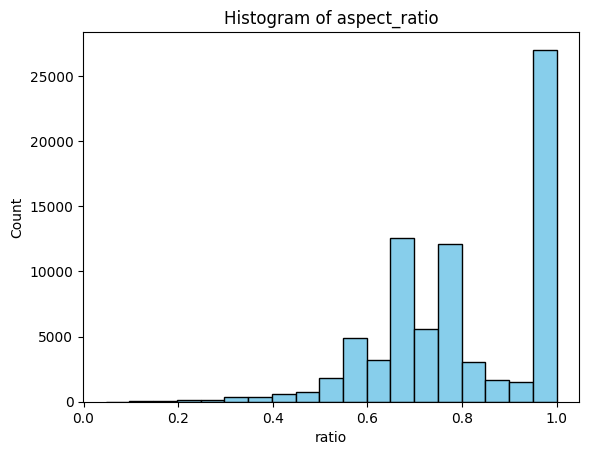

In [7]:
plt.hist(df['aspect_ratio'], bins=19, edgecolor='black', color='skyblue')
plt.xlabel('ratio')
plt.ylabel('Count')
plt.title('Histogram of aspect_ratio')

### Data preparing for instruction tuning



1. Create DataFrame from json data files which include questions and answers


In [ ]:
df_q = pd.read_json('data/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json')
df_a = pd.read_json('data/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json')

FileNotFoundError: File v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json does not exist

In [ ]:
df_q.head()

In [ ]:
df_a.head()

2. Combine questions and answers and create a new DataFrame according to the image_id and answer_id

In [ ]:
df_QA =  pd.merge(df_q, df_a, on=['question_id','image_id'], how='inner')
df_QA.head(15)

3. Change mutiple choice answers into a complete sentences

In [ ]:
df_QA['multiple_choice_answer'] = df_QA.apply(lambda col: "It's " + col['multiple_choice_answer'] if col['answer_type'] == 'other' else col['multiple_choice_answer'], axis = 1)
df_QA['multiple_choice_answer']

4. Add tags to indicate system prompt, user questions, and answers from the model

In [ ]:
df_QA['question'] = df_QA['question'].map(lambda x: '<user>' + x+'</user>')
df_QA['multiple_choice_answer'] = df_QA['multiple_choice_answer'].map(lambda x: '<assist>' + x+'</assist>')
df_QA['system_prompt'] = "<sys>You are a useful Visual Assitant</sys>"

5. Combine system prompt, user questions, and answers into one col and label them with corrsponding image_id


In [ ]:
df_QA['prompt'] = df_QA.apply(lambda row: f"{row['system_prompt']}{row['question']}{row['multiple_choice_answer']}", axis=1)

In [ ]:
df_final = df_QA[['image_id','prompt']]
df_final.head()

6. Output the data as csv file

In [ ]:
df_final.to_csv('output.csv', index=False)